3.Pokémon classifier
====================

In order to classify Pokémon images, we need to train a model with images of Pokémon and images of other classes.<br>
We will use transfer learning in order to speed up the training process.

Our problem is a classification with 150 classes, each for per Pokémon species.

- "Pokemon" dataset

## Download data from kaggle

In [1]:
 ! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bazema","key":"e852cc9b39f43cd198475361ec7aa1cb"}'}

In [3]:
 ! mkdir ~/.kaggle 

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d lantian773030/pokemonclassification

 99% 411M/417M [00:04<00:00, 78.7MB/s]
100% 417M/417M [00:04<00:00, 87.7MB/s]


In [ ]:
!mkdir data
!unzip pokemonclassification.zip -d data

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim.lr_scheduler as lr_scheduler
from torch import optim, nn
from torch.utils.data import RandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [9]:
import conf
import utils

## Load data and transform

In [10]:
def torch_transformations():
    mean_nums = [0.485, 0.456, 0.406]
    std_nums = [0.229, 0.224, 0.225]

    transform = {'train': transforms.Compose([
        transforms.Resize(size=300),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(size=256),
        transforms.RandomPerspective(),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)

    ]), 'val': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=256),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)

    ]), 'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=256),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
    ]),
    }
    return transform, std_nums, mean_nums

transform, std_nums, mean_nums = torch_transformations()

In [11]:
data_dir = 'data/PokemonData'

In [13]:
dataset = ImageFolder(data_dir, transform=transform['train'])

In [50]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# target array
targets = dataset.targets

# stratified split for validation
train_idx, test_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.15,
    shuffle=True,
    stratify=targets)

train_idx, valid_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    shuffle=True,
    stratify=targets)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

batch_size=16

train_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
test_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
len(train_dl), len(valid_dl), len(test_dl)

(341, 86, 64)

In [ ]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=False)
valid_dl = DataLoader(val_ds, batch_size, pin_memory=False)

## Visualize images after transformation 

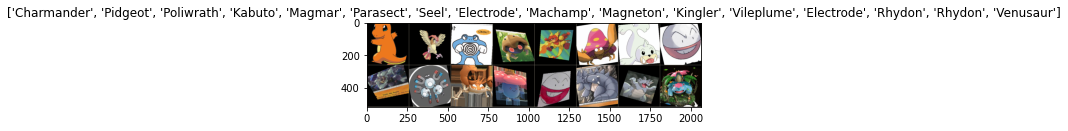

torch.Size([16, 3, 256, 256]) tensor([ 73, 147,  22, 140,  85, 116,  52,  38, 116, 140, 109,  34,  53,  11,
         39, 109])


In [22]:
utils.imshow_data_loader(train_dl, std_nums, mean_nums, conf.pokemons)

batch_x, batch_y = next(iter(train_dl))
print(np.shape(batch_x), batch_y)

## Define model and training functions

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    #validation step
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    #validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

class Net(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.net = models.resnet50(pretrained=True)
        num_ftrs = self.net.fc.in_features
        self.net.fc = nn.Linear(num_ftrs, 150)
        
    def forward(self, xb):
        return self.net(xb)


net = Net()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


## Data to GPU

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:
import torch.nn as nn

# getting default device
device = get_default_device()
print(device)
print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [28]:
if torch.cuda.is_available():
    net.to(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# inputs, labels = inputs.cuda(), labels.cuda()
# moving model to gpu
net = to_device(net, device); #Change the model no.

## Train a model

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.net.fc.parameters(), lr=0.01, momentum=0.9)

In [31]:
evaluate(net, val_loader=valid_dl)

{'val_acc': 0.009447674266994, 'val_loss': 5.049501419067383}

In [32]:
history = []
for epoch in range(5):  # loop over the dataset multiple times
    
    net.train()
    train_losses = []
    running_loss = 0.0

    for batch in train_dl:
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        loss = net.training_step(batch)
        #train_losses.append(loss)
        loss.backward()
        optimizer.step()
        
    result = evaluate(net, val_loader=valid_dl)
    running_loss += float(loss.item())
    result['train_loss'] = running_loss
    net.epoch_end(epoch, result)
    history.append(result)


print('Finished Training')


Epoch [0], train_loss: 2.2474, val_loss: 2.3699, val_acc: 0.4564
Epoch [1], train_loss: 1.7959, val_loss: 1.4963, val_acc: 0.6294
Epoch [2], train_loss: 1.2559, val_loss: 1.3637, val_acc: 0.6555
Epoch [3], train_loss: 1.0191, val_loss: 1.0855, val_acc: 0.7333
Epoch [4], train_loss: 0.3144, val_loss: 1.0156, val_acc: 0.7500
Finished Training


## Plot metrics

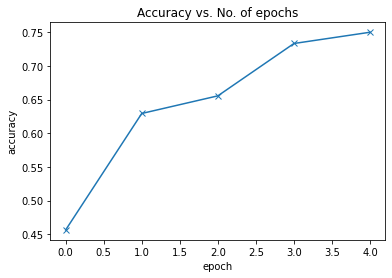

In [33]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
    
plot_accuracies(history)

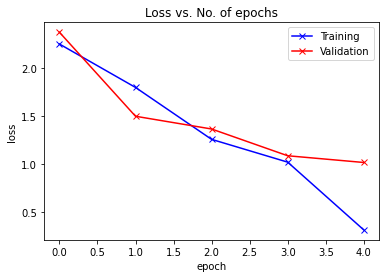

In [34]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
    
plot_losses(history)

In [35]:
PATH = './classifier_05_epoch.pth'

In [36]:
torch.save(net.state_dict(), PATH)

In [ ]:
net = Net()
net.load_state_dict({k.replace('module.',''):v for k,v in torch.load(PATH, map_location=torch.device('cpu')).items()})

<All keys matched successfully>

In [ ]:
net.to(device)

## Test model

In [37]:
from tqdm import tqdm
def visualize_model(model, valid_dl, classes, std_nums, mean_nums, device, num_images=6):
    was_training = model.training
    model.eval()
    plt.figure()

    with torch.no_grad():
        images_so_far = 0
        for batch in tqdm(valid_dl):
            images, labels = batch 
            print(labels)
            images = images.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            print('preds = ' + preds)

            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, ground truth: {}'
                             .format(classes[preds[j]],
                                     classes[labels[j]]))
                imshow_tensor(inputs.data[j], std_nums, mean_nums)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [38]:
def visualize_model(model, data_loaders, classes, std_nums, mean_nums, device, num_images=6):
    was_training = model.training
    model.eval()
    plt.figure()

    with torch.no_grad():
        images_so_far = 0
        for data in data_loaders:
            (inputs, labels) = data
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, ground truth: {}'
                             .format(classes[preds[j]],
                                     classes[labels[j]]))
                utils.imshow_tensor(inputs.cpu().data[j], std_nums, mean_nums)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

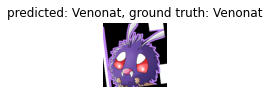

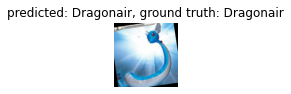

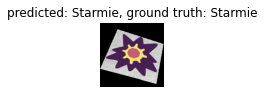

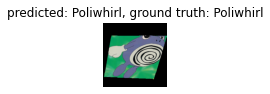

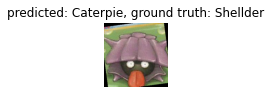

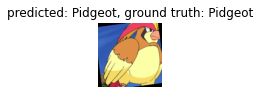

In [39]:
visualize_model(net, valid_dl, conf.pokemons, std_nums, mean_nums, device, num_images=6)

plt.ioff()
plt.show()

## Tests on new images

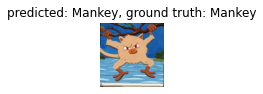

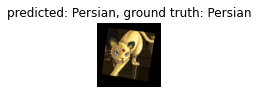

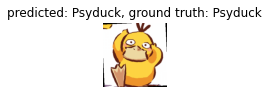

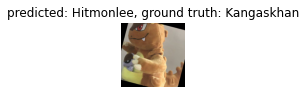

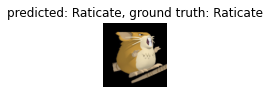

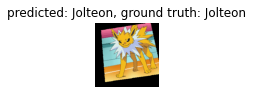

In [42]:
test_dl = DeviceDataLoader(test_dl, device)
visualize_model(net, test_dl, conf.pokemons, std_nums, mean_nums, device, num_images=6)

plt.ioff()
plt.show()

In [43]:
import pandas as pd
import matplotlib.ticker as mtick

def test_accuracy(model, data_loader, classes, figsize=(25, 8)):
    utils.global_accuracy(model, data_loader, classes)

    res = utils.accuracy_per_class(model, data_loader, classes)
    df = pd.DataFrame(res)
    df = df[(df != 0).all(1)]

    x = np.arange(len(df))

    width = 0.4

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_title('Accuracy per class')
    rects = ax.bar(x - width / 2, df[1], width)
    plt.xticks(x, df[0], rotation=90)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = int(rect.get_height())
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height + 1),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects)
    plt.show()

  0%|          | 0/64 [00:00<?, ?it/s]

Accuracy of the network on the test images: 82 %


100%|██████████| 64/64 [00:15<00:00,  4.12it/s]


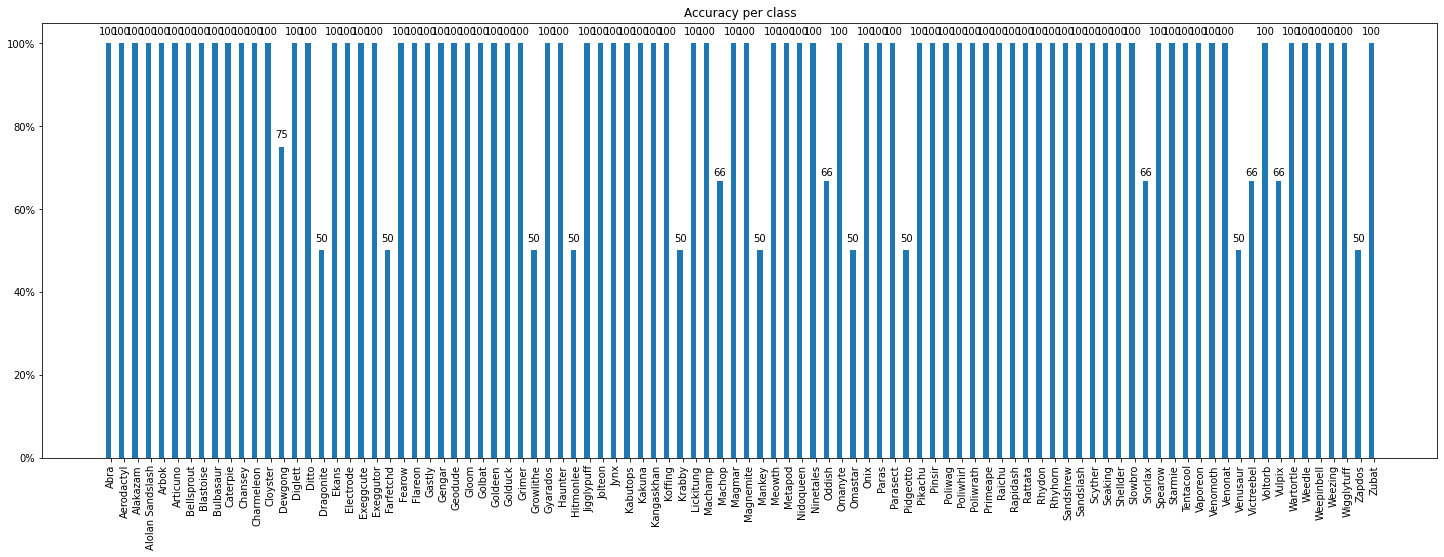

In [44]:
test_accuracy(net, test_dl, conf.pokemons)

## Interpretation

Our model as an accuracy of 82% on the test set, which is pretty great !